## Download dataset

In [ ]:
!wget https://datasets.simula.no/downloads/kvasir-seg.zip
!unzip kvasir-seg.zip

## Preprocess data

In [10]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os

In [3]:
# augment data
# Thay đổi độ sáng, độ tương phản, độ bão hòa và màu sắc. 
# Xác suất 50% lật ngang và lật dọc hình ảnh và mask tương ứng để gia tăng dữ liệu.
def default_augment_seg(input_image, input_mask):
    
    # Thay đổi độ sáng, độ tương phản, độ bão hòa và màu sắc. 
    # Độ sáng
    input_image = tf.image.random_brightness(input_image, 0.1)
    # Độ tương phản
    input_image = tf.image.random_contrast(input_image, 0.9, 1.1)
    # Độ bão hòa
    input_image = tf.image.random_saturation(input_image, 0.9, 1.1)
    # Màu hue
    input_image = tf.image.random_hue(input_image, 0.01)
    # Lật hình ảnh ngẫu nhiên với xác suất 50%
    # Lật ngang
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    # Lật dọc
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_up_down(input_image)
        input_mask = tf.image.flip_up_down(input_mask)

    return input_image, input_mask

# Data augmentation
def BatchAdvAugmentSeg(imagesT, masksT):
    images, masks = default_augment_seg(imagesT, masksT)
    return images, masks

def build_decoder(with_labels=True, target_size=(256, 256), ext='png', segment=False, ext2='png'):
    # Tiền xử lý đối với dữ liệu hình ảnh với kích thước là target_size
    def decode(path):
        file_bytes = tf.io.read_file(path)
        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels=3, dct_method='INTEGER_ACCURATE')
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3, dct_method='INTEGER_ACCURATE')
        else:
            raise ValueError("Image extension not supported")

        img = tf.image.resize(img, target_size)
        # Trả về kết quả là hình ảnh có kích thước target_size
        return img
    
    # Tiền xử lý đối với dữ liệu mask  
    def decode_mask(path, gray=True):
        file_bytes = tf.io.read_file(path)
        if ext2 == 'png':
            img = tf.image.decode_png(file_bytes, channels=3)
        elif ext2 in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3)
        else:
            raise ValueError("Image extension not supported")

        img = tf.image.rgb_to_grayscale(img) if gray else img
        img = tf.image.resize(img, target_size)
        img = tf.cast(img, tf.float32) / 255.0

        return img

    # Chuẩn bị dữ liệu với label
    def decode_with_labels(path, label):
        return decode(path), label
    
    # Chuẩn bị dữ liệu với mask
    def decode_with_segments(path, path2, gray=True):
        return decode(path), decode_mask(path2, gray)

    if segment:
        return decode_with_segments

    return decode_with_labels if with_labels else decode

# Data augmentation
# Thay đổi độ sáng, độ tương phản, độ bão hòa và màu sắc. 
# Random lật ngang và lật dọc hình ảnh và mask tương ứng để gia tăng dữ liệu.
def build_augmenter(with_labels=True):
    def augment(img):

        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_flip_left_right(img)
        # Giá trị parameter trong các hàm để chỉ định mức tối đa và tối thiểu có thể thay đổi độ sáng, tuonwg phản, bão hòa và màu
        img = tf.image.random_brightness(img, 0.1)
        img = tf.image.random_contrast(img, 0.9, 1.1)
        img = tf.image.random_saturation(img, 0.9, 1.1)
        img = tf.image.random_hue(img, 0.02)

        return img

    def augment_with_labels(img, label):
        return augment(img), label

    return augment_with_labels if with_labels else augment

# Xây dựng dataset
def build_dataset(paths, labels=None, bsize=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, shuffle=1024,
                  cache_dir=""):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)

    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)

    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)

    AUTO = tf.data.experimental.AUTOTUNE
    # Tạo slice từ đường dẫn và label 
    slices = paths if labels is None else (paths, labels)
    dset = tf.data.Dataset.from_tensor_slices(slices)
    # Map dữ liệu với dữ liệu đã được tiền xử lý
    dset = dset.map(decode_fn, num_parallel_calls=AUTO)
    # Tạo bộ dữ liệu đệm 
    dset = dset.cache(cache_dir) if cache else dset
    # Data augmentation
    dset = dset.map(augment_fn, num_parallel_calls=AUTO) if augment else dset
    # Trộn dữ liệu với shuffle size là shuffle
    dset = dset.shuffle(shuffle) if shuffle else dset
    # Tạo batch với batch_size = bsize
    dset = dset.batch(bsize)
    dset = dset.prefetch(AUTO)

    return dset

In [4]:
# Load dữ liệu
def load_dataset(route, img_size = 256):
    BATCH_SIZE = 1
    X_path = '{}/images/'.format(route)
    Y_path = '{}/masks/'.format(route)
    X_full = sorted(os.listdir(f'{route}/images'))
    Y_full = sorted(os.listdir(f'{route}/masks'))

    X_train = [X_path + x for x in X_full]
    Y_train = [Y_path + x for x in Y_full]

    test_decoder = build_decoder(with_labels=True, target_size=(img_size, img_size), ext='jpg', segment=True, ext2='jpg')
    # Tạo dataset
    test_dataset = build_dataset(X_train, Y_train, bsize=BATCH_SIZE, decode_fn=test_decoder,
                                augmentAdv=False, augment=False, augmentAdvSeg=False, shuffle = None)
    return test_dataset, len(X_train)

In [16]:
route = './Kvasir-SEG'
X_path = './Kvasir-SEG/images/'
Y_path = './Kvasir-SEG/masks/'
img_size = 224
BATCH_SIZE = 16
SEED = 42

In [14]:
X_full = sorted(os.listdir(f'{route}/images'))
Y_full = sorted(os.listdir(f'{route}/masks'))

print(len(X_full))

valid_size = 0.2
test_size = 0.2

X_train, X_valid = train_test_split(X_full, test_size=valid_size, random_state=SEED)
Y_train, Y_valid = train_test_split(Y_full, test_size=valid_size, random_state=SEED)

X_train, X_test = train_test_split(X_train, test_size=test_size, random_state=SEED)
Y_train, Y_test = train_test_split(Y_train, test_size=test_size, random_state=SEED)

X_train = [X_path + x for x in X_train]
X_valid = [X_path + x for x in X_valid]
X_test = [X_path + x for x in X_test]

Y_train = [Y_path + x for x in Y_train]
Y_valid = [Y_path + x for x in Y_valid]
Y_test = [Y_path + x for x in Y_test]

print("N Train:", len(X_train))
print("N Valid:", len(X_valid))
print("N test:", len(X_test))

1000
N Train: 640
N Valid: 200
N test: 160


In [17]:
train_decoder = build_decoder(with_labels=True, target_size=(img_size, img_size), ext='jpg', segment=True, ext2='jpg')
train_dataset = build_dataset(X_train, Y_train, bsize=BATCH_SIZE, decode_fn=train_decoder,
                            augmentAdv=False, augment=False, augmentAdvSeg=True)

valid_decoder = build_decoder(with_labels=True, target_size=(img_size, img_size), ext='jpg', segment=True, ext2='jpg')
valid_dataset = build_dataset(X_valid, Y_valid, bsize=BATCH_SIZE, decode_fn=valid_decoder,
                            augmentAdv=False, augment=False, repeat=False, shuffle=False,
                            augmentAdvSeg=False)

test_decoder = build_decoder(with_labels=True, target_size=(img_size, img_size), ext='jpg', segment=True, ext2='jpg')
test_dataset = build_dataset(X_test, Y_test, bsize=BATCH_SIZE, decode_fn=test_decoder,
                            augmentAdv=False, augment=False, repeat=False, shuffle=False,
                            augmentAdvSeg=False)

In [19]:
steps_per_epoch = len(X_train) // BATCH_SIZE
print(steps_per_epoch)

40


## Visualization

In [33]:
import matplotlib.pyplot as plt
from glob import glob
import random

In [35]:
name = [path.split("/")[-1][:-4] for path in glob(X_path+"*")]

In [42]:
import pandas as pd
df = pd.read_json('./Kvasir-SEG/kavsir_bboxes.json')

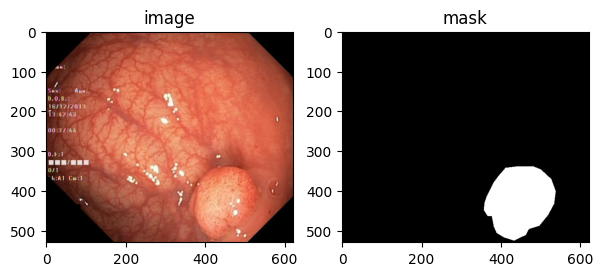

In [47]:
example = random.choices(name)[0]
# print(df[example]["bbox"])
image = plt.imread(f"./Kvasir-SEG/images/{example}.jpg")
mask = plt.imread(f"./Kvasir-SEG/masks/{example}.jpg")

plt.figure(figsize=(7,7))
plt.subplot(121)
plt.imshow(image)
plt.title("image")

plt.subplot(122)
plt.imshow(mask)
plt.title("mask")
plt.show()